In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from seaborn import countplot

In [2]:
# Make use of GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Dataset
class PMTDataset(Dataset):
    def __init__(self, csv_file):

        self.df = pd.read_csv(csv_file, encoding= 'unicode_escape')
        countplot(x='isKilled', data=self.df)
        self.y = torch.tensor(pd.Series(np.where(self.df.isKilled.values == 'yes', 1.0, 0.0), self.df.index).to_numpy()).to(device)
        self.X = torch.tensor(pd.get_dummies(self.df, columns=["operator", "methodReturn"]).drop("isKilled", axis=1).to_numpy()).to(device)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [4]:
# Model
class Net(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, h1_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(h1_size, h2_size)
        self.l3 = nn.Linear(h2_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x.float())
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out
        

In [46]:
# Hyperparameters
input_size = 48
h1_size = 32
h2_size = 32
num_classes = 2
num_epochs = 50
batch_size = 5000
learning_rate = 0.001

torch.Size([29591, 48]) torch.Size([29591])


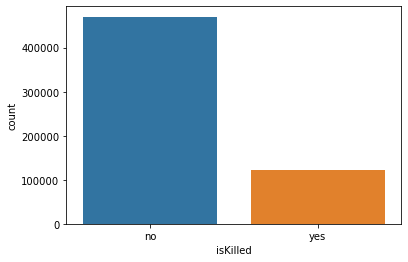

In [41]:
train_dataset = PMTDataset("training_data.csv")
train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset)//20 +1, shuffle=True)
# test_dataset = PMTDataset("testing_data.csv")
test_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

In [42]:
model = Net(input_size, h1_size, h2_size, num_classes).to(device)

#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# LR scheduler
lambda1 = lambda epoch: 0.99
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lambda1)

In [50]:
#training loop
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        # print(features.dtype, labels.dtype)
        features = features.type(torch.LongTensor).to(device)
        labels = labels.type(torch.LongTensor).to(device)

        #forward
        outputs = model(features)
        #print(outputs.dtype)
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (i+1) % 100 == 0:
        print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{total_steps}, loss = {loss.item():.4f}')
    scheduler.step()
    

epoch 1 / 50, step 1/20, loss = 3.0846
epoch 1 / 50, step 2/20, loss = 1.9138
epoch 1 / 50, step 3/20, loss = 2.8708
epoch 1 / 50, step 4/20, loss = 1.9087
epoch 1 / 50, step 5/20, loss = 18.1513
epoch 1 / 50, step 6/20, loss = 0.9450
epoch 1 / 50, step 7/20, loss = 273.1560
epoch 1 / 50, step 8/20, loss = 33.0798
epoch 1 / 50, step 9/20, loss = 1.0773
epoch 1 / 50, step 10/20, loss = 26.6498
epoch 1 / 50, step 11/20, loss = 213.4536
epoch 1 / 50, step 12/20, loss = 6.3026
epoch 1 / 50, step 13/20, loss = 9.1773
epoch 1 / 50, step 14/20, loss = 8.5746
epoch 1 / 50, step 15/20, loss = 5.8464
epoch 1 / 50, step 16/20, loss = 4.7491
epoch 1 / 50, step 17/20, loss = 6.6047
epoch 1 / 50, step 18/20, loss = 6.9681
epoch 1 / 50, step 19/20, loss = 116.5712
epoch 1 / 50, step 20/20, loss = 2.9578
epoch 2 / 50, step 1/20, loss = 8.0901
epoch 2 / 50, step 2/20, loss = 3.6554
epoch 2 / 50, step 3/20, loss = 7.5400
epoch 2 / 50, step 4/20, loss = 9.6514
epoch 2 / 50, step 5/20, loss = 325.9551
epo

In [51]:
# testing loop

with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for features, labels in test_loader:
        features = features.type(torch.LongTensor).to(device)
        labels = labels.type(torch.LongTensor)
        outputs = model(features)

        _, predictions = torch.max(outputs, 1)
        predictions = predictions.to('cpu')
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        print(confusion_matrix(labels, predictions))

    acc = 100.0 * n_correct / n_samples
    print('accuracy =', acc)

[[443380  26810]
 [ 12011 109612]]
accuracy = 93.44032658964909


In [43]:
features = pd.read_csv('training_data.csv', encoding= 'unicode_escape')

In [44]:
features = pd.get_dummies(features, columns=["operator", "methodReturn"]).drop("isKilled", axis=1)

In [51]:
features = torch.tensor(features.values)

In [52]:
features[[0,1]]

tensor([[2.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 3.6400e+02,
         1.6000e+01, 4.2000e-02, 1.2000e+01, 1.7000e+01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 3.6400e+02,
         1.6000e+01, 4.2000e-02, 1.2000e+01, 1.7000e+01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000

In [49]:
torch.save(model, 'C:\\Users\\prava\\OneDrive\\Documents\\UVA\\Semester 2\\CS6316 - Machine Learning\\Project\\models\\32-32--20.pt')